In [1]:
# workaround via specifying an invalid value first
# %config Application.log_level='WORKAROUND'
# => fails, necessary on Fedora 27, ipython3 6.2.1
# %config Application.log_level='DEBUG'
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from polaris.anomaly import detector

from betsi import models, preprocessors, predictors
import json
from sklearn.model_selection import train_test_split
from polaris.data.readers import read_polaris_data



In [84]:
# Plot configurations
plt.rcParams["figure.figsize"] = (25,8)

# Fetching/Loading Data with Polaris tools

In [3]:
# Collect the file the first time with one of the following commands
#!polaris fetch  -s 2019-09-01 -e 2019-09-20 LightSail-2 ls2-2019-09-01-to-2019-09-20.json
#!polaris fetch --skip_normalizer -s 2021-03-01 -e 2021-05-05 BOBCAT-1 ../data/bobcat1-2021-03-01-to-2021-05-05.json

In [4]:
#M = read_polaris_data("../data/bobcat1-2021-03-01-to-2021-05-05.json")


M = read_polaris_data("../data/bobcat1-2021-04-01-to-2021-04-25T02-13-00-skipped-normalizer.json")


# Data from 2021-04-25T02-13-43 upt o 2021-05-05 collected by Hugh
M2  = read_polaris_data("../data/bobcat1-normalized_frames-recent.json")


# Using Betsi

## Selecting numerical and variable dataset

### Using polaris metadata

In [5]:
type(M[0])

polaris.dataset.metadata.PolarisMetadata

In [6]:
type(M[1])

pandas.core.frame.DataFrame

In [7]:

# Selection per polaris metadata information
column_selection = [c for c in M[0]["analysis"]["column_tags"] if M[0]["analysis"]["column_tags"][c] == "variable" ]
column_selection2 = [c for c in M2[0]["analysis"]["column_tags"] if M2[0]["analysis"]["column_tags"][c] == "variable" ]

In [8]:
# using the greatest number of 


print("if M has more variables, then these would be missing")
M2not_inM = [c for c in column_selection2 if c not in column_selection]
print(M2not_inM)

print("if M2 has more variables, then this would be missing")
Mnot_inM2 = [c for c in column_selection if c not in column_selection2]
print(Mnot_inM2)

print("----")

all_selection = column_selection2
if len(column_selection) > len(column_selection2):
    all_selection = column_selection
    print("M has more variable columns that M2\n")
    all_selection.extend(M2not_inM)
else: 
    print("M2 has more variable columns that M\n")
    all_selection.extend(Mnot_inM2)

print("Missing variables where added and kept")

if M has more variables, then these would be missing
['sdr_i', 'bootcount_p31', 'bootcause_p31', 'bootcause_a3200', 'resetcause_a3200', 'bootcause_ax100']
if M2 has more variables, then this would be missing
['data', 'tot_rx_count', 'tot_rx_bytes']
----
M2 has more variable columns that M

Missing variables where added and kept


### Concatenating data and removing all remaining non numerical columns

In [9]:
data = pd.concat([M[1][all_selection], M2[1][all_selection]])

In [10]:
# Overal check of all present variables types
all_types = [data[col].dtype for col in data.columns]
print("{} columns in M with types from (dtype('O') is Object):".format(len(all_types)))
print(np.unique(np.sort(all_types)))


63 columns in M with types from (dtype('O') is Object):
[dtype('float64') dtype('O')]


In [12]:
data.shape

(4209, 63)

In [13]:
all_numerical_cols = [col for col in all_selection 
                      if data[col].dtype  == "float64" or data[col].dtype == "int64"]
print(all_numerical_cols)

['type', 'a3200_hktable_17_1_timestamp', 'a3200_hktable_10_timestamp', 'bc1_wdcnt', 'adcs_mode', 'a3200_hktable_17_2_timestamp', 'time', 'a3200_hktable0_timestamp', 'bat_v', 'bat_i_in', 'bat_i_out', 'solar1_i', 'solar1_v', 'solar2_i', 'solar2_v', 'solar3_i', 'solar3_v', 'sdr_i', 'bootcount_p31', 'bootcause_p31', 'bootcount_a3200', 'bootcause_a3200', 'resetcause_a3200', 'uptime_a3200', 'temp_mcu', 'i_gssb1', 'i_pwm', 'panel_temp1', 'panel_temp2', 'panel_temp3', 'panel_temp4', 'panel_temp5', 'panel_temp6', 'panel_temp7', 'panel_temp8', 'panel_temp9', 'p31_temp1', 'p31_temp2', 'p31_temp3', 'p31_temp4', 'p31_temp5', 'p31_temp6', 'flash1_free', 'ax100_telemtable_timestamp', 'temp_brd', 'temp_pa', 'bgnd_rssi', 'tot_tx_count', 'tot_tx_bytes', 'bootcount_ax100', 'bootcause_ax100', 'deploy_attempts1', 'deploy_attempts2', 'deploy_attempts3', 'deploy_attempts4', 'gyro_x', 'gyro_y', 'gyro_z', 'timestamp', 'data', 'tot_rx_count', 'tot_rx_bytes']


In [14]:
# Final data column selection

data = data[all_numerical_cols]
print(data.shape)
data.head()

(4209, 62)


type  a3200_hktable_17_1_timestamp  a3200_hktable_10_timestamp  bc1_wdcnt  \
0   1.0                           NaN                         NaN        NaN   
1   3.0                  1.617240e+09                1.617240e+09     5649.0   
2   NaN                           NaN                         NaN        NaN   
3   NaN                           NaN                         NaN        NaN   
4   NaN                           NaN                         NaN        NaN   

   adcs_mode  a3200_hktable_17_2_timestamp          time  \
0        NaN                           NaN  1.617240e+09   
1        0.0                  1.617240e+09  1.617240e+09   
2        NaN                           NaN  1.617240e+09   
3        NaN                           NaN  1.617240e+09   
4        NaN                           NaN  1.617240e+09   

   a3200_hktable0_timestamp    bat_v  bat_i_in  ...  deploy_attempts2  \
0              1.617240e+09  16601.0      74.0  ...               NaN   
1                       NaN      NaN       NaN  ...               NaN   
2                       NaN      NaN       NaN  ...               NaN   
3                       NaN      NaN       NaN  ...               NaN   
4                       NaN      NaN       NaN  ...               NaN   

   deploy_attempts3  deploy_attempts4  gyro_x  gyro_y  gyro_z  timestamp  \
0               NaN               NaN     NaN     NaN     NaN        NaN   
1               NaN               NaN     NaN     NaN     NaN        NaN   
2               NaN               NaN     NaN     NaN     NaN        NaN   
3               NaN               NaN     NaN     NaN     NaN        NaN   
4               NaN               NaN     NaN     NaN     NaN        NaN   

           data  tot_rx_count  tot_rx_bytes  
0  2.310504e+09     1709399.0    64698614.0  
1  2.310504e+09           NaN           NaN  
2           NaN           NaN           NaN  
3           NaN           NaN           NaN  
4           NaN           NaN           NaN  

[5 rows x 62 columns]

## Data preparation for the betsi auto-encoder based method

### Saving time index

In [44]:
# Keeping time index for later usage
time_index = pd.to_datetime(data.time, unit="s")
print(time_index.describe())

# Because data was built from 2 different dataframes.
time_index.index = range(time_index.shape[0])

count                    4209
unique                   3244
top       2021-04-25 14:45:35
freq                        4
first     2021-04-01 01:18:17
last      2021-05-04 23:52:27
Name: time, dtype: object


### Normalizing data for neural network input

In [16]:
print(data.isna().sum())
print("\n\t Although we have NaN we will imput them on the normalized data")

type                             675
a3200_hktable_17_1_timestamp    1948
a3200_hktable_10_timestamp      1948
bc1_wdcnt                       1948
adcs_mode                       1948
                                ... 
gyro_z                          3787
timestamp                       3787
data                             253
tot_rx_count                    2936
tot_rx_bytes                    2936
Length: 62, dtype: int64

	 Although we have NaN we will imput them on the normalized data


In [17]:
# Step 1: Normalize the data
ndata, normalizer = preprocessors.normalize_all_data(data)

ndata = ndata.apply(lambda col: col.fillna(col.mean()),axis=0)

In [18]:
# Step 2: Convert it to columns using fixed stride and window size using Betsi preprocessor
window_size = 10
stride = 5
converted_data = preprocessors.convert_to_column(ndata, window_size=window_size, stride=stride)
print(converted_data.shape)

(841, 620)


In [19]:
# This should be zero here
converted_data.isna().sum().sum()

0

In [20]:
print("The input data {} has {} features all included and {} observations".format(ndata.shape, ndata.shape[1], ndata.shape[0]))
print("Window size is {}\nand stride is {}\n\t ==> thus generating a matrix for neural network input of size {}".format(window_size, stride, converted_data.shape))
print("\n\tFor info {}(observations)/{}(stride) = {}".format(ndata.shape[0], stride, ndata.shape[0]/stride))

The input data (4209, 62) has 62 features all included and 4209 observations
Window size is 10
and stride is 5
	 ==> thus generating a matrix for neural network input of size (841, 620)

	For info 4209(observations)/5(stride) = 841.8


## Neural Network settings

In [21]:
optimizer = "adam"
loss = "mean_squared_error"
metrics = "MSE"
layer_dims = [ converted_data.shape[1], 100, 30]
print(layer_dims)

[620, 100, 30]


In [22]:
# by Default layer activiations are ReLu
ae_model, en_model, de_model = models.custom_autoencoder(layer_dims) #, activations=activations)
# Compile the model for training
ae_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
en_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
de_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Fit and evaluate model

In [25]:
train_data, test_data = train_test_split(
        converted_data,
        test_size=0.10, # usually 33% of data is for testing, 
        shuffle=False, # We disable shuffling since order matters (time)
    )

# You can also play around with the batch_size and epochs and enable
# early_stopping based on your needs
history = ae_model.fit(train_data, train_data, batch_size=32, epochs=1000)

# To test the model to check if it has overfit, you can run:
ae_model.evaluate(test_data, test_data, batch_size=32)

Epoch 1/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2561 - MSE: 0.2519
Epoch 2/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2507 - MSE: 0.2466
Epoch 3/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.2438 - MSE: 0.2399
Epoch 4/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.2386 - MSE: 0.2349
Epoch 5/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.2349 - MSE: 0.2313
Epoch 6/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2321 - MSE: 0.2286
Epoch 7/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.2306 - MSE: 0.2272
Epoch 8/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2289 - MSE: 0.2256
Epoch 9/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2281 - MSE: 0.2249
Epoch 10/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2275 - MSE: 0.2243
Epoch 11/1000
24/24 [============================

24/24 [==============================] - 0s 2ms/step - loss: 0.2217 - MSE: 0.2194
Epoch 87/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2216 - MSE: 0.2194
Epoch 88/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2216 - MSE: 0.2194
Epoch 89/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2216 - MSE: 0.2193
Epoch 90/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2216 - MSE: 0.2193
Epoch 91/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2219 - MSE: 0.2196
Epoch 92/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2218 - MSE: 0.2195
Epoch 93/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2218 - MSE: 0.2196
Epoch 94/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2220 - MSE: 0.2198
Epoch 95/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2220 - MSE: 0.2198
Epoch 96/1000
24/24 [==============================] -

24/24 [==============================] - 0s 2ms/step - loss: 0.2195 - MSE: 0.2174
Epoch 171/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2195 - MSE: 0.2174
Epoch 172/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2196 - MSE: 0.2175
Epoch 173/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2196 - MSE: 0.2175
Epoch 174/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2196 - MSE: 0.2175
Epoch 175/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2197 - MSE: 0.2176
Epoch 176/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2198 - MSE: 0.2177
Epoch 177/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2200 - MSE: 0.2179
Epoch 178/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2201 - MSE: 0.2180
Epoch 179/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2202 - MSE: 0.2181
Epoch 180/1000
24/24 [=======================

24/24 [==============================] - 0s 2ms/step - loss: 0.2187 - MSE: 0.2167
Epoch 255/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.2189 - MSE: 0.2168
Epoch 256/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.2190 - MSE: 0.2169
Epoch 257/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2192 - MSE: 0.2172
Epoch 258/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.2191 - MSE: 0.2170
Epoch 259/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.2188 - MSE: 0.2167
Epoch 260/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.2186 - MSE: 0.2165
Epoch 261/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.2183 - MSE: 0.2162
Epoch 262/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.2181 - MSE: 0.2161
Epoch 263/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2181 - MSE: 0.2160
Epoch 264/1000
24/24 [=======================

24/24 [==============================] - 0s 3ms/step - loss: 0.2180 - MSE: 0.2160
Epoch 339/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.2179 - MSE: 0.2159
Epoch 340/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.2177 - MSE: 0.2158
Epoch 341/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.2176 - MSE: 0.2157
Epoch 342/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.2177 - MSE: 0.2157
Epoch 343/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.2176 - MSE: 0.2156
Epoch 344/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.2177 - MSE: 0.2157
Epoch 345/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.2179 - MSE: 0.2159
Epoch 346/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.2181 - MSE: 0.2162
Epoch 347/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.2183 - MSE: 0.2163
Epoch 348/1000
24/24 [=======================

24/24 [==============================] - 0s 3ms/step - loss: 0.2172 - MSE: 0.2152
Epoch 423/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.2171 - MSE: 0.2152
Epoch 424/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.2171 - MSE: 0.2151
Epoch 425/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.2170 - MSE: 0.2151
Epoch 426/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.2171 - MSE: 0.2152
Epoch 427/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.2171 - MSE: 0.2152
Epoch 428/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.2171 - MSE: 0.2152
Epoch 429/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.2172 - MSE: 0.2153
Epoch 430/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.2173 - MSE: 0.2154
Epoch 431/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.2175 - MSE: 0.2156
Epoch 432/1000
24/24 [=======================

24/24 [==============================] - 0s 2ms/step - loss: 0.2180 - MSE: 0.2161
Epoch 507/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.2181 - MSE: 0.2162
Epoch 508/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2180 - MSE: 0.2161
Epoch 509/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.2180 - MSE: 0.2161
Epoch 510/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2179 - MSE: 0.2160
Epoch 511/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.2179 - MSE: 0.2159
Epoch 512/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2178 - MSE: 0.2159
Epoch 513/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2176 - MSE: 0.2157
Epoch 514/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2175 - MSE: 0.2156
Epoch 515/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2175 - MSE: 0.2156
Epoch 516/1000
24/24 [=======================

24/24 [==============================] - 0s 2ms/step - loss: 0.2181 - MSE: 0.2162
Epoch 591/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2178 - MSE: 0.2159
Epoch 592/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2176 - MSE: 0.2157
Epoch 593/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2175 - MSE: 0.2156
Epoch 594/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2175 - MSE: 0.2156
Epoch 595/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2175 - MSE: 0.2156
Epoch 596/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.2173 - MSE: 0.2155
Epoch 597/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2174 - MSE: 0.2155
Epoch 598/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2174 - MSE: 0.2156
Epoch 599/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2173 - MSE: 0.2155
Epoch 600/1000
24/24 [=======================

24/24 [==============================] - 0s 2ms/step - loss: 0.2172 - MSE: 0.2154
Epoch 675/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2172 - MSE: 0.2154
Epoch 676/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2172 - MSE: 0.2154
Epoch 677/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2172 - MSE: 0.2154
Epoch 678/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2171 - MSE: 0.2153
Epoch 679/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2172 - MSE: 0.2153
Epoch 680/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2173 - MSE: 0.2155
Epoch 681/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2173 - MSE: 0.2155
Epoch 682/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2172 - MSE: 0.2154
Epoch 683/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2173 - MSE: 0.2155
Epoch 684/1000
24/24 [=======================

24/24 [==============================] - 0s 2ms/step - loss: 0.2168 - MSE: 0.2150
Epoch 759/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2168 - MSE: 0.2150
Epoch 760/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2169 - MSE: 0.2151
Epoch 761/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2169 - MSE: 0.2152
Epoch 762/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2170 - MSE: 0.2153
Epoch 763/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2174 - MSE: 0.2156
Epoch 764/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2176 - MSE: 0.2158
Epoch 765/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2177 - MSE: 0.2158
Epoch 766/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2176 - MSE: 0.2158
Epoch 767/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2176 - MSE: 0.2158
Epoch 768/1000
24/24 [=======================

24/24 [==============================] - 0s 3ms/step - loss: 0.2164 - MSE: 0.2146
Epoch 843/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.2163 - MSE: 0.2146
Epoch 844/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2163 - MSE: 0.2146
Epoch 845/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2164 - MSE: 0.2146
Epoch 846/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2164 - MSE: 0.2147
Epoch 847/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2164 - MSE: 0.2147
Epoch 848/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2165 - MSE: 0.2147
Epoch 849/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2166 - MSE: 0.2149
Epoch 850/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2170 - MSE: 0.2153
Epoch 851/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2175 - MSE: 0.2157
Epoch 852/1000
24/24 [=======================

24/24 [==============================] - 0s 2ms/step - loss: 0.2173 - MSE: 0.2155
Epoch 927/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2173 - MSE: 0.2155
Epoch 928/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2171 - MSE: 0.2153
Epoch 929/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2170 - MSE: 0.2152
Epoch 930/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2168 - MSE: 0.2150
Epoch 931/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2168 - MSE: 0.2151
Epoch 932/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2168 - MSE: 0.2151
Epoch 933/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2168 - MSE: 0.2150
Epoch 934/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2167 - MSE: 0.2150
Epoch 935/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.2168 - MSE: 0.2150
Epoch 936/1000
24/24 [=======================

[0.44214531779289246, 0.43819940090179443]

In [24]:
train_data.shape

(563, 620)

## Running betsi analysis

### Predict and calculate feature-kernel distances 

In [26]:
# Step 1: Predict the "bottleneck" layer representation for the input data
data_rep = en_model.predict(converted_data)

# Step 2: Measure the distance between consecutive timestamps. This will be
# the metric to detect anomalies. Distance here refers to the L2 norm.
distance_list = []
for row_no in range(data_rep.shape[0] - 1):
    distance_list.append(
        predictors.distance_measure(data_rep[row_no], data_rep[row_no + 1]))

(841, 30)


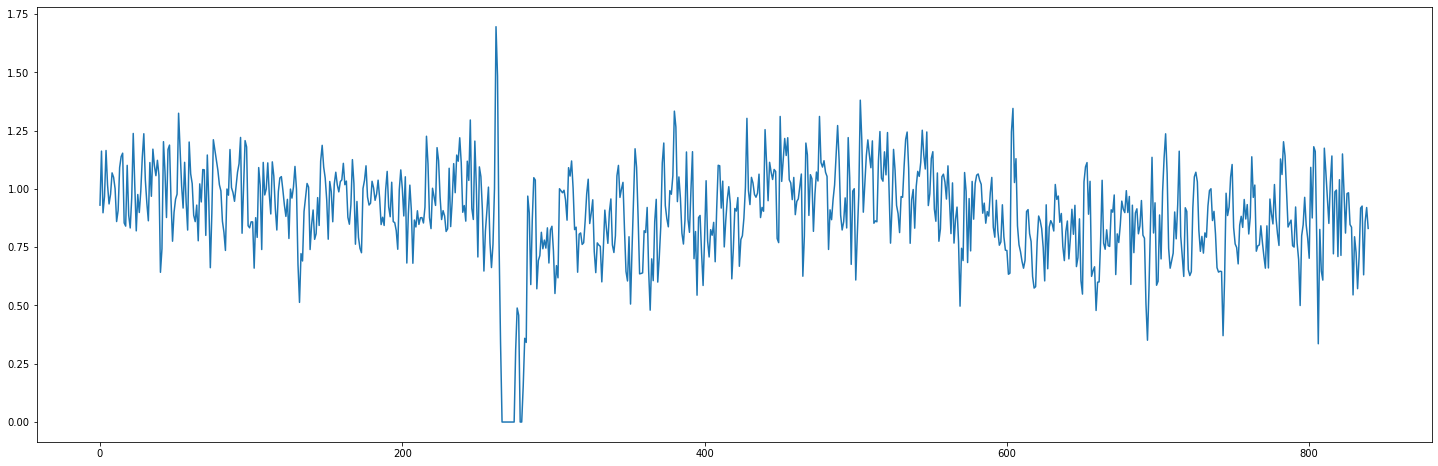

In [108]:
print(data_rep.shape)

plt.plot(distance_list)

In [27]:
# Step 3: Detect the events. We have a noise_margin_per variable to say
# how much (in percentage) should the value be above the average to be
# considered the event. Try playing around with this to find the best value!
noise_margin_per = 50 # 2.5 x the average ie 150% more than average
events = predictors.get_events(distance_list, threshold=noise_margin_per)

In [28]:
print("{} events detected with {}% average deviation".format(len(events), noise_margin_per))
print(events)

28 events detected with 50% average deviation
[15, 52, 64, 84, 93, 120, 152, 161, 176, 199, 257, 360, 428, 436, 464, 488, 493, 508, 530, 604, 614, 621, 696, 711, 725, 755, 788, 815]


### Plot events on the data

In [ ]:
#df_test = pd.read_pickle("/tmp/test_data.pkl")

# df_test = pd.read_pickle("/tmp/test_data.pkl")
# events = json.load(open("/tmp/anomaly_metrics.json"))["events"]

In [98]:
# events by order of breakage (difference with previous behavior) in DESC order (biggest first)
sorted_dist = np.argsort(distance_list)[::-1]
events_sorted = [evt for evt in sorted_dist if evt in events]

In [99]:
events_sorted

[604,
 52,
 428,
 488,
 93,
 508,
 15,
 815,
 696,
 161,
 176,
 199,
 725,
 464,
 436,
 120,
 152,
 257,
 84,
 530,
 493,
 64,
 614,
 711,
 621,
 755,
 788,
 360]

In [100]:
print(distance_list[604])
print(distance_list[360])

1.3452192796862152
0.8205231637419066


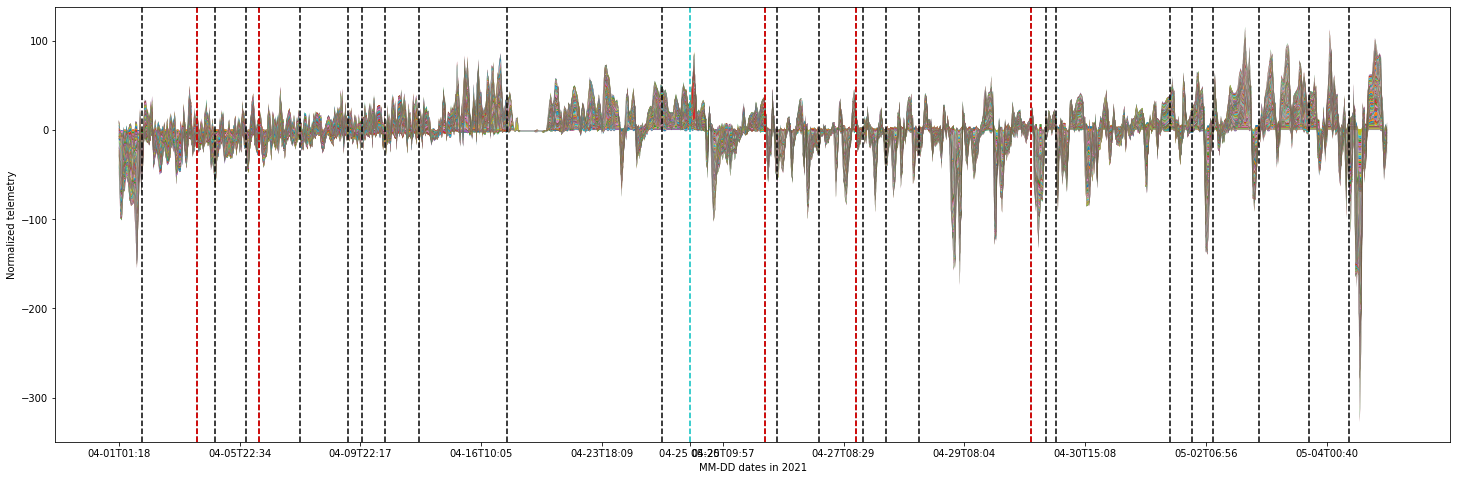

<Figure size 1800x576 with 0 Axes>

In [123]:
plt.close()

ndf = converted_data.to_numpy()

# Time index with one point every stride
ndf_time = (time_index.iloc[::stride]).iloc[:-1]

# To remove columns of data which are constant
#ndf[:, ~np.all(ndf[1:] == ndf[:-1], axis=0)]

# tot_cols = ndf.shape[1] # Not used
tot_rows = ndf.shape[0]

# Creating the stack plot
plt.stackplot(range(ndf.shape[0]), ndf.T)
#plt.stackplot(ndf_time.to_numpy().T, ndf.T)



# Plotting the events on top of the stackplots as dotted lines
for xc in events:
    if xc > tot_rows:
        # Just a fail-safe, made some mistakes before
        break
    #plt.axvline(ndf_time.iloc[xc], color="k", linestyle="--")
    plt.axvline(xc, color="k", linestyle="--")

# Plotting in red the 3 biggest changes
for xc in events_sorted[:5]:
    if xc > tot_rows:
        # Just a fail-safe, made some mistakes before
        break
    #plt.axvline(ndf_time.iloc[xc], color="k", linestyle="--")
    plt.axvline(xc, color="r", linestyle="--")

    
    


At = list(range(ndf.shape[0])[::80])
At_time_str = [str(d)[5:16] for d in ndf_time.to_numpy()[At]]

big_event_idx =  378
At.append(big_event_idx)
At_time_str.append(str(ndf_time.iloc[big_event_idx])[5:16] )
plt.xticks(At, At_time_str)
plt.axvline(big_event_idx, color="c", linestyle="--")

plt.xlabel("MM-DD dates in 2021")
plt.ylabel("Normalized telemetry")
plt.show()
plt.savefig("ttttt.png")

In [109]:
ndf.shape[0]

841

In [162]:
str(ndf_time.iloc[378])

'2021-04-25 05:20:43'

In [161]:
378 in events

False

### Brownbag analysis

In [115]:
ndf_time.iloc[378]

Timestamp('2021-04-25 05:20:43')

In [119]:
ndf_time.iloc[360]

Timestamp('2021-04-24 15:38:14')

In [136]:
# Trying to see how much apart the betsi breakpoint (first datetime) is from information from operators (second datetime)
time_index[(time_index > '2021-04-24 15:38:14') & (time_index <= '2021-04-25 05:20:43')]

1803   2021-04-24 15:38:43
1804   2021-04-24 15:38:43
1805   2021-04-24 15:38:43
1806   2021-04-24 15:38:44
1807   2021-04-24 15:38:44
               ...        
1888   2021-04-25 05:20:42
1889   2021-04-25 05:20:42
1890   2021-04-25 05:20:43
1891   2021-04-25 05:20:43
1892   2021-04-25 05:20:43
Name: time, Length: 90, dtype: datetime64[ns]

In [165]:
def plot_events_against_real_telemetry(df, events_timestamps=None, savefig="/tmp/hhh.svg"):
    """ Tailored for a dataframe df that has a time column
    """
    plt.close()
    time_idx = pd.to_datetime(df.time, unit="s")
    # In case the time_idx has a wrong numbering
    time_idx.index = range(time_idx.shape[0])
    df.index = time_idx
    
    #plt.stackplot(range(df.shape[0]), df.T)
    normalized_df=(df-df.min())/(df.max()-df.min())
    #print(normalized_df.head())
    plt.plot(normalized_df, "ko", alpha=0.05)
    
    if events_timestamps is not None:
        for evt in events_timestamps:
            plt.axvline(evt, color="r", linestyle="--", linewidth="4", alpha=0.7)
            print(evt)
            
    plt.axvline('2021-04-25 05:20:43', color="c", linestyle="--", linewidth="4", alpha=0.9)
    plt.xlabel("Timestamp")
    plt.ylabel("Normalized telemetry")
    
    plt.savefig(savefig)
    
    plt.show()
    print()

2021-04-01 18:18:16
2021-04-04 03:26:43
2021-04-04 21:44:11
2021-04-06 00:13:35
2021-04-06 16:52:32
2021-04-07 19:12:37
2021-04-09 00:42:05
2021-04-09 22:21:16
2021-04-10 19:44:32
2021-04-12 10:20:29
2021-04-20 05:01:18
2021-04-24 15:38:14
2021-04-25 16:24:34
2021-04-26 07:41:02
2021-04-27 05:08:00
2021-04-28 01:11:00
2021-04-28 02:47:30
2021-04-28 06:02:58
2021-04-29 01:52:58
2021-04-30 05:47:56
2021-04-30 07:18:56
2021-04-30 07:27:56
2021-05-01 12:44:01
2021-05-02 04:02:30
2021-05-02 07:00:32
2021-05-03 01:32:30
2021-05-03 10:57:28
2021-05-04 05:27:28


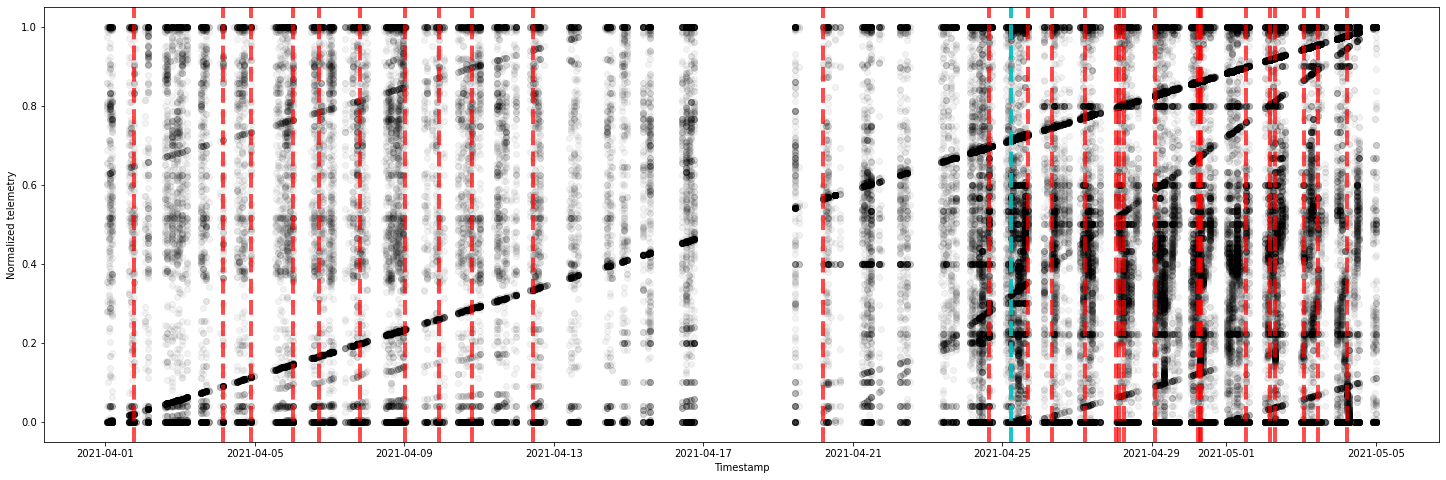

In [166]:
plot_events_against_real_telemetry(data, ndf_time.iloc[events])

In [150]:
# The window time of window_size
time_index[window_size] - time_index[0] 

Timedelta('0 days 00:55:00')

In [188]:
def extract_datasets_around_event(df, timeref, events_list, event_index=10, base_name="../data/bobcat-1-behavior-data"):
    D1 = df[(df.index > timeref.iloc[events_list[event_index-1]]) & (df.index <= timeref.iloc[events_list[event_index]])]
    D2 = df[(df.index > timeref.iloc[events_list[event_index]]) & (df.index <= timeref.iloc[events_list[event_index+1]])]
    print("Two datasets around {}".format(timeref.iloc[events_list[event_index]]))
    D1.to_csv(base_name+"-B1.csv")
    D2.to_csv(base_name+"-B2.csv")
    

In [184]:
ndf_time.iloc[events[9]]

Timestamp('2021-04-12 10:20:29')

In [187]:
extract_datasets_around_event(data, ndf_time, events, 10)

Two datasets around 2021-04-20 05:01:18


In [189]:
extract_datasets_around_event(data, ndf_time, events, 9, base_name="../data/bobcat-1-behavior-around-2021-04-12")

Two datasets around 2021-04-12 10:20:29


## Comparing graphs of two consecutive behavior periods

In [218]:
graph_before = "../data/bobcat-1-behavior-around-2021-04-12-BEFORE.json"
graph_after  = "../data/bobcat-1-behavior-around-2021-04-12-AFTER.json"
graph_after_after  = "../data/bobcat-1-behavior-around-2021-04-12-AFTER-AFTER.json"

In [216]:
def compare_two_graphs(gbefore, gafter):
    with open(gbefore, "r") as fff:
        json_before = json.load(fff)
    
    with open(gafter, "r") as fff:
        json_after = json.load(fff)
        
    for node in json_after["graph"]["nodes"]:
        if node not in json_before["graph"]["nodes"]:
            print("missing node from before: "+node)
                 
    for node in json_before["graph"]["nodes"]:
        if node not in json_after["graph"]["nodes"]:
            print("missing node from after: "+node)
            
    #uniqsrc = np.uniq([elt["source"] for elt in json_after["graph"]["links"]])
    
    def build_link_db(graph):
        db = {}
        for elt in graph["graph"]["links"]:
            if elt["source"] not in db:
                db[elt["source"]] = {}
            db[elt["source"]][elt["target"]] = elt["value"]
        return db
    
    after_db = build_link_db(json_after)
    before_db = build_link_db(json_before)
    for src in after_db:
        if src in before_db:
            for target in after_db[src]:
                if target in before_db[src]:
                    A = after_db[src][target]
                    B = before_db[src][target]
                    adiff = np.abs(A-B)
                    if adiff > 0.0:
                        if A > B:
                            A = B
                        if A/adiff > 0.2:
                            print("Consequent change on pair {} --> {} = from {} to {} ".format(
                                  src, target, before_db[src][target], after_db[src][target]))
                else:
                    print("New pair from already existing source {} --> {} = {} ".format(src, target, after_db[src][target]))
        else:
            print("No links were present before from that paramater:   "+src)
            for target in after_db[src]:
                print("\t--> "+target)

In [217]:
compare_two_graphs(graph_before, graph_after)

New pair from already existing source a3200_hktable_17_1_timestamp --> a3200_hktable_10_timestamp = 1.0 
New pair from already existing source a3200_hktable_17_1_timestamp --> a3200_hktable_17_2_timestamp = 1.0 
New pair from already existing source a3200_hktable_17_1_timestamp --> time.1 = 0.23441638052463531 
New pair from already existing source a3200_hktable_17_1_timestamp --> a3200_hktable0_timestamp = 0.26385921239852905 
New pair from already existing source a3200_hktable_17_1_timestamp --> bootcount_a3200 = 0.5815030336380005 
New pair from already existing source a3200_hktable_17_1_timestamp --> ax100_telemtable_timestamp = 0.36011406779289246 
Consequent change on pair a3200_hktable_17_1_timestamp --> tot_tx_count = from 0.19264103472232819 to 0.4315612018108368 
Consequent change on pair a3200_hktable_17_1_timestamp --> tot_tx_bytes = from 0.13054786622524261 to 0.45864996314048767 
New pair from already existing source a3200_hktable_17_1_timestamp --> deploy_attempts1 = 1.0

In [219]:
compare_two_graphs(graph_after, graph_after_after)

New pair from already existing source a3200_hktable_17_1_timestamp --> bc1_wdcnt = 0.9503037929534912 
Consequent change on pair a3200_hktable_17_1_timestamp --> time.1 = from 0.23441638052463531 to 0.30380892753601074 
Consequent change on pair a3200_hktable_17_1_timestamp --> a3200_hktable0_timestamp = from 0.26385921239852905 to 0.3737714886665344 
New pair from already existing source a3200_hktable_17_1_timestamp --> solar2_v = 0.10120600461959839 
New pair from already existing source a3200_hktable_17_1_timestamp --> solar3_v = 0.10294892638921738 
Consequent change on pair a3200_hktable_17_1_timestamp --> ax100_telemtable_timestamp = from 0.36011406779289246 to 0.3737714886665344 
Consequent change on pair a3200_hktable_17_1_timestamp --> tot_tx_bytes = from 0.45864996314048767 to 0.16880464553833008 
Consequent change on pair a3200_hktable_17_1_timestamp --> timestamp = from 0.3080316185951233 to 0.23969678580760956 
No links were present before from that paramater:   bc1_wdcnt


In [220]:
compare_two_graphs(graph_before, graph_after_after)

New pair from already existing source a3200_hktable_17_1_timestamp --> a3200_hktable_10_timestamp = 1.0 
New pair from already existing source a3200_hktable_17_1_timestamp --> bc1_wdcnt = 0.9503037929534912 
New pair from already existing source a3200_hktable_17_1_timestamp --> a3200_hktable_17_2_timestamp = 1.0 
New pair from already existing source a3200_hktable_17_1_timestamp --> time.1 = 0.30380892753601074 
New pair from already existing source a3200_hktable_17_1_timestamp --> a3200_hktable0_timestamp = 0.3737714886665344 
New pair from already existing source a3200_hktable_17_1_timestamp --> solar2_v = 0.10120600461959839 
New pair from already existing source a3200_hktable_17_1_timestamp --> solar3_v = 0.10294892638921738 
New pair from already existing source a3200_hktable_17_1_timestamp --> ax100_telemtable_timestamp = 0.3737714886665344 
Consequent change on pair a3200_hktable_17_1_timestamp --> tot_tx_bytes = from 0.13054786622524261 to 0.16880464553833008 
New pair from alr